# Vector Embeddings of Log Lines with BERT
This notebook demonstrates the embedding of log line samples into a vector space based on [Sentence-Bert](https://www.sbert.net), an extension to the `BERT` model.

The log line samples orignate from [Loghub](https://github.com/logpai/loghub).



### Imports

In [29]:
from sentence_transformers import util
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# custom
from src.embedder import get_embedding, get_tsne_embedding
from src.data import pre_process, get_labels, delete_bgl_labels, get_binary_labels, get_idc, get_log_labels
from src.utils import get_cosine_distances, get_distance_metrics, get_local_cosine_distances, get_local_distance_metrics, load_logs, load_anomaly_logs

### Data Entry

In [30]:
### set sentence transformer model type
model_name = 'all-mpnet-base-v2'
# model_name = 'all-MiniLM-L12-v2'

### set log file and format
log_file   = 'BGL_2k.log'  
log_format = '<Label> <Id> <Date> <Code1> <Time> <Code2> <Component1> <Component2> <Level> <Content>'  # BGL log format
# log_file = 'Thunderbird_sample.log'
# log_format = '<Label> <Timestamp> <Date> <User> <Month> <Day> <Time> <Location> <Component>(\[<PID>\])?: <Content>'  # Thunderbird log format

### setting a seed for reproducibility (optional)
np.random.seed(42)

### Pre - Processing

In [31]:
# loads and parses logs with drain logparser
pre_process(log_format, log_file)
labels = get_labels(log_file)
delete_bgl_labels(log_file)

Parsing file: ./logs/BGL_2k.log
Total size after encoding is 2000 2000
Parsing done. [Time taken: 0:00:01.005025]


### Embedding Computation

In [32]:
### code to compute embedding with getting rid of the labels
embedding_processed_nolabel = get_embedding(log_file, model_name, processed_flag=True, label_flag=False)
embedding_unprocessed_nolabel = get_embedding(log_file, model_name, processed_flag=False, label_flag=False)


## Evaluation

### Plot functions

In [33]:
def plot_sim_matrix(embedding1, embedding2, idc: list, labels: list):
    """ plots cosine similarity matrix 
    Params:
        embedding 1: embedding to compare
        embedding 2: embedding to compare
        idc (list[int]): list of indices of log lines that should be included in plot
        labels (list[str]): list of labels
    """
    # plot_logs = []
    cos_scores = util.cos_sim(embedding1, embedding2)

    # convert to numpy to leverage np.ix_function
    # NOTE: conversion leads to loss of accuracy, but for plotting it is ok
    cos_scores_np = cos_scores.numpy()
    sim_matrix = cos_scores_np[np.ix_(idc, idc)]

    # plot
    fig, ax = plt.subplots(figsize=(6,6))
    cax = ax.matshow(sim_matrix, interpolation='nearest')
    plt.title("Cosine Similarity Matrix for Log Lines")
    plt.xticks(range(len(idc)), labels[idc[0]:idc[-1]+1], rotation=90)
    plt.yticks(range(len(idc)), labels[idc[0]:idc[-1]+1])
    fig.colorbar(cax)
    plt.show()

def plot_distance_table(embedding, idc_anomaly, idc_no_anomaly):
    """ plots table with min, max and mean of cos scores for embedding
    Params:
        embedding:
        idc_anomaly:
        idc_no_anomaly:
    """

    cos_scores_all, cos_scores_n2n, cos_scores_a2a, cos_scores_n2a = get_cosine_distances(embedding, idc_anomaly, idc_no_anomaly)

    all_min, all_max, all_mean = get_distance_metrics(cos_scores_all)
    n2n_min, n2n_max, n2n_mean = get_distance_metrics(cos_scores_n2n)
    a2a_min, a2a_max, a2a_mean = get_distance_metrics(cos_scores_a2a)
    n2a_min, n2a_max, n2a_mean = get_distance_metrics(cos_scores_n2a)

    cell_text = [
        [all_min, all_max, all_mean],
        [n2n_min, n2n_max, n2n_mean],
        [a2a_min, a2a_max, a2a_mean],
        [n2a_min, n2a_max, n2a_mean]
    ]
    rows = ["all with all", "normal with normal", "anomaly with anomaly", "normal with anomaly"]
    cols = ["Minimum", "Maximum", "Mean"]

    fig, ax = plt.subplots() 
    ax.set_axis_off()        
    the_table = plt.table(cellText=cell_text,
                        rowLabels=rows,
                        colLabels=cols,
                        cellLoc='center',
                        loc='upper left')
    plt.show() 


def plot_local_distance_table(embedding, idc_anomaly, idc_no_anomaly, epsilon):
    """ plots table with min, max and mean of cos scores for embedding
    Params:
        embedding:
        idc_anomaly:
        idc_no_anomaly:
        epsilon (int): (window size / 2) - 1
    """
    cos_scores_all, cos_scores_n2n, cos_scores_a2a, cos_scores_n2a = get_local_cosine_distances(embedding, idc_anomaly, idc_no_anomaly, epsilon)

    all_min, all_max, all_mean = get_local_distance_metrics(cos_scores_all)
    n2n_min, n2n_max, n2n_mean = get_local_distance_metrics(cos_scores_n2n)
    a2a_min, a2a_max, a2a_mean = get_local_distance_metrics(cos_scores_a2a)
    n2a_min, n2a_max, n2a_mean = get_local_distance_metrics(cos_scores_n2a)

    cell_text = [
        [all_min, all_max, all_mean],
        [n2n_min, n2n_max, n2n_mean],
        [a2a_min, a2a_max, a2a_mean],
        [n2a_min, n2a_max, n2a_mean]
    ]
    rows = ["all with all", "normal with normal", "anomaly with anomaly", "normal with anomaly"]
    cols = ["Minimum", "Maximum", "Mean"]

    fig, ax = plt.subplots() 
    ax.set_axis_off()        
    the_table = plt.table(cellText=cell_text,
                        rowLabels=rows,
                        colLabels=cols,
                        cellLoc='center',
                        loc='upper left')
    plt.show() 


def plot_tsne_embedding(tsne_results, binary_labels, classes):
    """ plots tsne embedding
    Params:
        tsne_results (array[n_samples, n_components]): Embedding of the training data in low-dimensional space.
        binary_labels (list): returns list with entry 0 for no anomaly and 1 for anomaly
        classes (list): string labels for anomaly and no anomaly that are displayed in legend
    """
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=binary_labels)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)    
    plt.show()
    

### Plots

#### t-SNE Embedding Plot

Showing high-dimensional embedding in 2 dimensions

/Users/jantiegges/.pyenv/versions/3.8.12/envs/bert-for-log-lines/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jantiegges/.pyenv/versions/3.8.12/envs/bert-for-log-lines/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


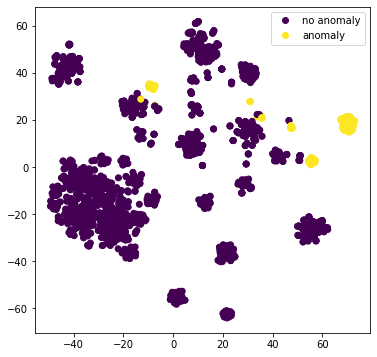

In [34]:
tsne_results = get_tsne_embedding(embedding_processed_nolabel, n_dim=2)
classes = ["no anomaly", "anomaly"]
binary_labels = get_binary_labels(labels)
plot_tsne_embedding(tsne_results, binary_labels, classes)

#### K-Means Clustering

In [35]:
anomaly_logs = load_anomaly_logs(f"./logs/{log_file}")
log_labels = get_log_labels(log_file)

### set number of clusters
# num_clusters = len(set(log_labels))
num_clusters = 1

# Perform kmean clustering until there are no more mixed clusters
num_clust_mixed = 1
while(num_clust_mixed != 0):

    num_clusters += 1

    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embedding_processed_nolabel)
    cluster_assignment = clustering_model.labels_

    clustered_sentences = [[] for i in range(num_clusters)]
    corpus = load_logs(f"./logs/{log_file}")
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clustered_sentences[cluster_id].append(corpus[sentence_id])

    num_clust_anomaly = 0
    num_clust_mixed = 0
    num_clust_normal_distinct = 0
    num_clust_anomaly_distinct = 0

    for i, cluster in enumerate(clustered_sentences):
        anomaly_count = 0
        for log in cluster:
            if log in anomaly_logs:
                anomaly_count += 1
        if (anomaly_count > 0):
            num_clust_anomaly += 1
        clust_ratio = anomaly_count / len(cluster)
        if (clust_ratio == 1):
            num_clust_anomaly_distinct += 1
        elif (clust_ratio == 0):
            num_clust_normal_distinct += 1
        else:
            num_clust_mixed += 1

    if (num_clusters % 10 == 0):
        print(f"Clusters: {num_clusters} - Mixed Clusters: {num_clust_mixed}")

    ### define if clustering is done
    #break

print(num_clusters)
print(num_clust_anomaly)
print(num_clust_mixed)
print(num_clust_normal_distinct)
print(num_clust_anomaly_distinct)

14
4
3
10
1


#### Similarity Matrix

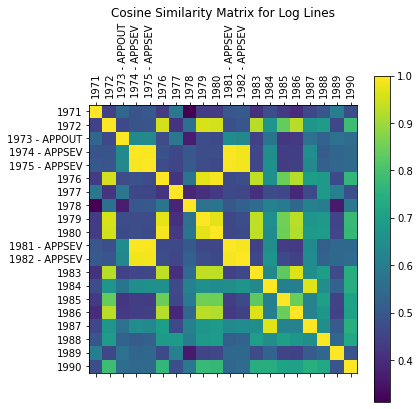

In [40]:
idc = range(1970, 1990)
plot_sim_matrix(embedding_processed_nolabel, embedding_processed_nolabel, idc, labels)

#### Cosine Distance Table Comparison

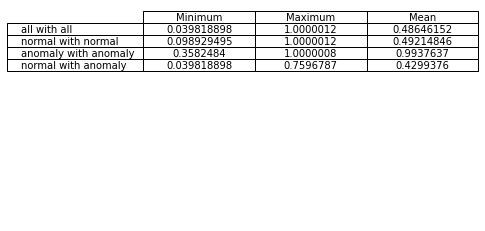

In [ ]:
# table of distance metrics

labels = get_labels(log_file)
idc_anomaly, idc_no_anomaly = get_idc(labels)

plot_distance_table(embedding_processed_nolabel, idc_anomaly, idc_no_anomaly)

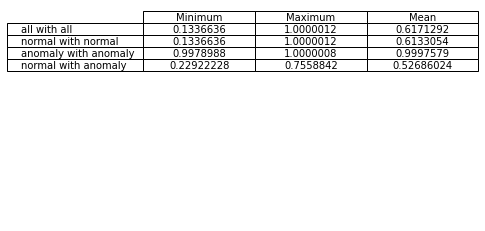

In [ ]:
# table of distance metrix for epsilon lines around one line
# might not work for block anomalies (limitation)

labels = get_labels(log_file)
idc_anomaly, idc_no_anomaly = get_idc(labels)

epsilon = 10
plot_local_distance_table(embedding_processed_nolabel, idc_anomaly, idc_no_anomaly, epsilon)